# Import Data


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from config import *
config_chapter4()
# This is needed to render the plots in this chapter
from plots.chapter4 import *

Finished!


In [4]:
import random 
import numpy as np 
from PIL import Image 

import torch
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler 
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
%matplotlib inline 

from data_generation.image_classification import generate_dataset 
from stepbystep.v0 import StepByStep 
from plots.chapter4 import *

# Classifying Images

## Data Generation

In [5]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)


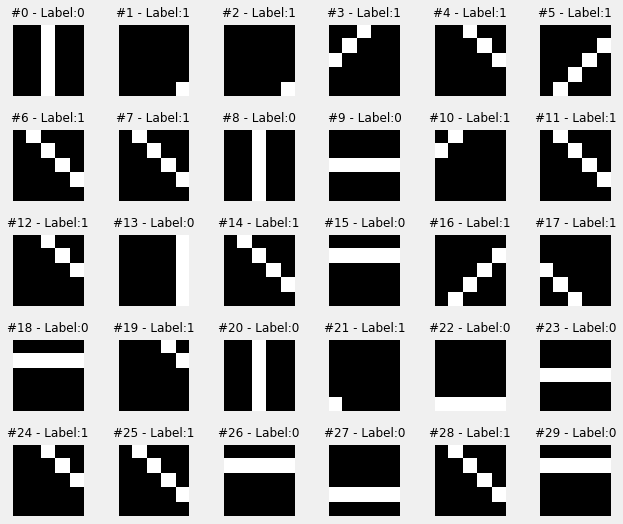

In [6]:
fig = plot_images(images, labels, n_plot=30)

## Images and Channels

In [7]:
image_r = np.zeros((5, 5), dtype=np.uint8) 
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [8]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

In [9]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

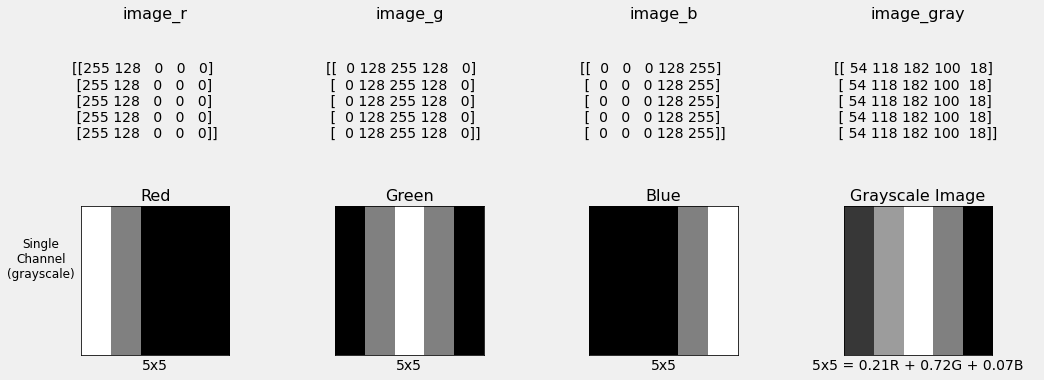

In [10]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

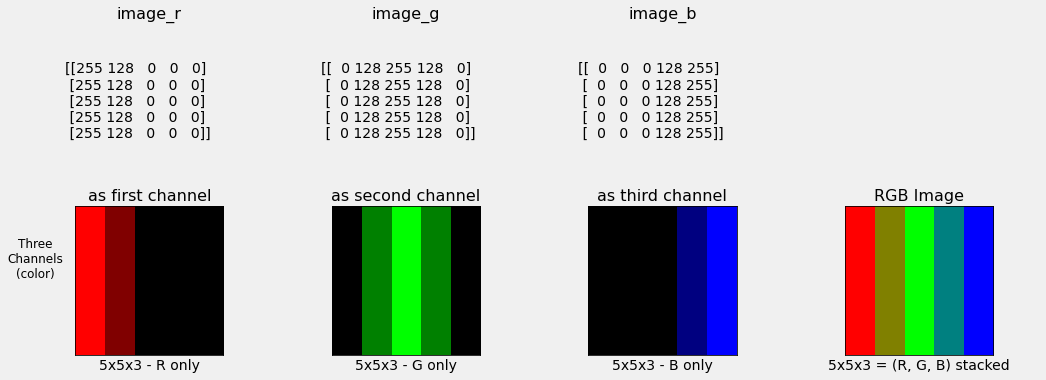

In [11]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

### NCHW vs NHWC

In [12]:
images.shape

(300, 1, 5, 5)

In [13]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [14]:
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [15]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## TorchVision

### Transforms

In [16]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [17]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [18]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


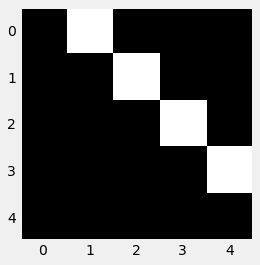

In [19]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

### Transforms on Images

In [20]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

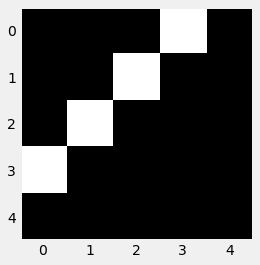

In [21]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)


### Transform on Tensors

In [22]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

#### Normalize Transform

$$
\Large 
\begin{aligned}
input = 0 \implies \frac{0-mean}{std}= \frac{0-0.5}{0.5}&=-1
\\
input = 1 \implies \frac{1-mean}{std}= \frac{1-0.5}{0.5}&=1
\end{aligned}
$$

In [23]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

### Composing Transforms

In [24]:
composer = Compose([RandomHorizontalFlip(p=1.0), Normalize(mean=(.5,), std=(.5,))])

In [25]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [26]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


In [27]:
example_tensor = torch.as_tensor(example/ 255).float()

## Data Preparation

In [28]:
# Builds tensors from numpy arrays BEFORE split 
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

### Data Transforms

In [29]:
class TransformedTensorDataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.transform = transform 

  def __getitem__(self, index):
    x = self.x[index]

    if self.transform:
      x = self.transform(x)

    return x, self.y[index]

  def __len__(self):
    return len(self.x)

In [30]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

In [31]:
len(dataset)

300

In [32]:
dataset[0]

(tensor([[[-1., -1.,  1., -1., -1.],
          [-1., -1.,  1., -1., -1.],
          [-1., -1.,  1., -1., -1.],
          [-1., -1.,  1., -1., -1.],
          [-1., -1.,  1., -1., -1.]]]), tensor([0.]))

### Subset Random Sampler

### Helper Function #4

In [33]:
def index_splitter(n, splits, seed=13):
  idx = torch.arange(n)
  # Makes the split argument a tensor 
  splits_tensor = torch.as_tensor(splits)
  # Finds the correct multiplier, so we don't have 
  # to worry about summing up to N (or one)
  multiplier = n / splits_tensor.sum()
  splits_tensor = (multiplier * splits_tensor).long()
  # If there is a difference, throws at the first split
  # so random_split does not complain 
  diff = n - splits_tensor.sum()
  splits_tensor[0] += diff
  # Uses PyTorch random_split to split the indices
  torch.manual_seed(seed)
  return random_split(idx, splits_tensor)


In [34]:
tensor1 = torch.as_tensor([80, 20])
tensor1

tensor([80, 20])

In [35]:
tensor1.sum()

tensor(100)

In [36]:
st = 200 / tensor1.sum()

In [37]:
st

tensor(2.)

In [38]:
st1 = (st * tensor1)
st1

tensor([160.,  40.])

In [39]:
st2 = (st * tensor1).long()
st2

tensor([160,  40])

In [40]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [41]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [42]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [43]:
# Builds a loader of each set
train_loader = DataLoader(dataset = dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset = dataset, batch_size=16, sampler=val_sampler)

In [44]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

### Data Augmentation Transformations

In [45]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [46]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([ Normalize(mean=(.5,), std=(.5,))])

In [47]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Weighted Random Sampler

In [48]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


In [49]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

In [50]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [51]:
y_train_tensor[:10].squeeze().long()

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [52]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights = sample_weights,
    num_samples = len(sample_weights),
    generator = generator,
    replacement = True
)

In [53]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Helper Function #5

In [54]:
def make_balanced_sampler(y):
  # Computes weights for compensating imbalanced classes
  classes, counts = y.unique(return_counts=True)
  weights = 1.0 / counts.float()
  sample_weights = weights[y.squeeze().long()]
  # Builds sampler with computer weights
  generator = torch.Generator()
  sampler = WeightedRandomSampler(
      weights = sample_weights,
      num_samples = len(sample_weights),
      generator = generator,
      replacement = True
  )
  return sampler

In [55]:
sampler = make_balanced_sampler(y_train_tensor)

### Seeds and more (seeds)

In [56]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

In [57]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

In [58]:
def set_seed(self, seed=42):
  torch.backends.cudnn.deterministric = True
  torch.backends.cudnn.benchmark = False
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  try:
    self.train_loader.sampler.generator.manual_seed(seed)
  except:
    pass
    

In [59]:
setattr(StepByStep, 'set_seed', set_seed)

### Putting It Altogether

In [60]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and 
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split 
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set 
train_composer = Compose([RandomHorizontalFlip(p=.5),
                            Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])


# Uses custome dataset to apply composed transorms to each set 
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)


# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)


# Use sampler in the training set to get a balanced data loader 
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)





### Pixels as Features

In [61]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [62]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


## Shallow Model

$$
\Large P(y=1) = \sigma(z) = sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$

### Notation 

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X = 
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T \cdot X 
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\cdot
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}} 
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\cdot
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration


In [63]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model 
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines SGD optimizer to update the parameters
optimizer_logisitic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a cross entropy loss function 
binary_loss_fn = nn.BCELoss()

### Model Training

In [64]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logisitic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

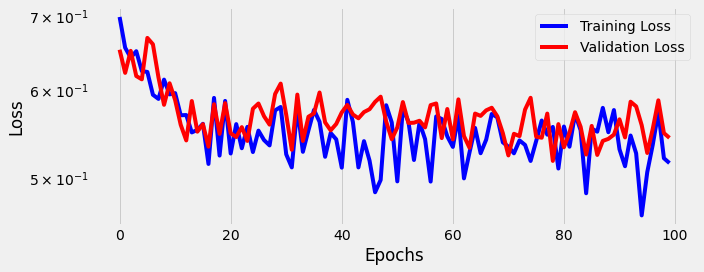

In [65]:
fig = sbs_logistic.plot_losses()

## Deep-ish Model

### Model Configuration

In [66]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model 
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function 
binary_loss_fn = nn.BCELoss()

### Model Training

In [67]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

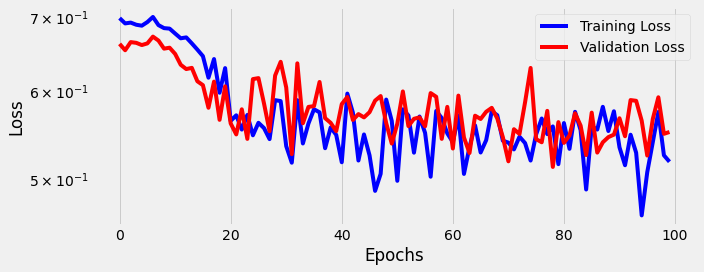

In [68]:
fig = sbs_nn.plot_losses()

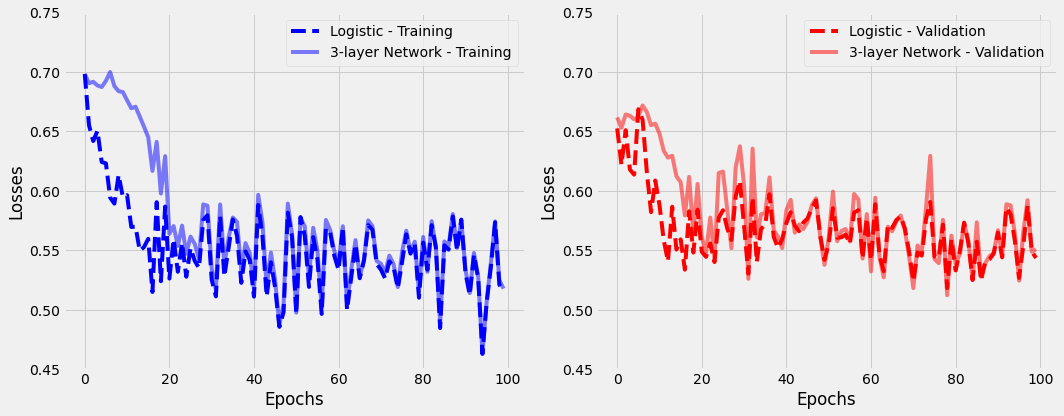

In [69]:
fig = figure5(sbs_logistic, sbs_nn)

### Show Me the Code!

In [70]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [71]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [72]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [73]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

torch.Size([1, 25])

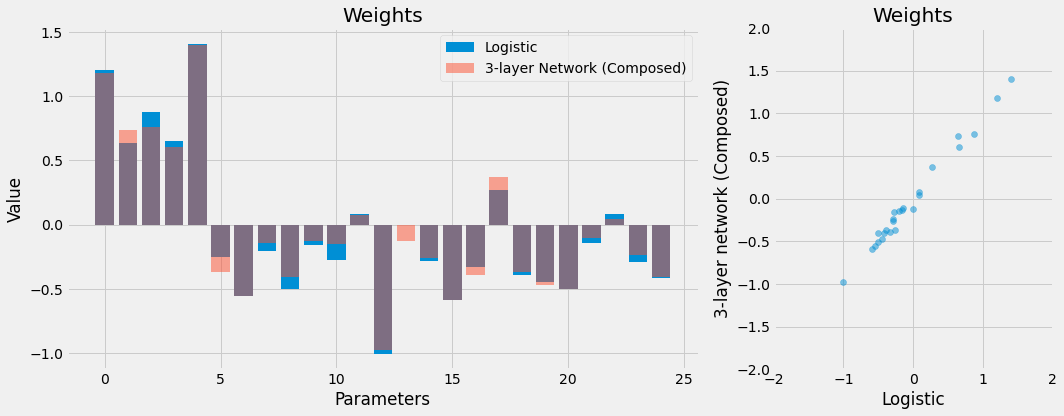

In [74]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

In [77]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [78]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

### Weights as Pixels

In [79]:
w_nn_hidden0.shape

torch.Size([5, 25])

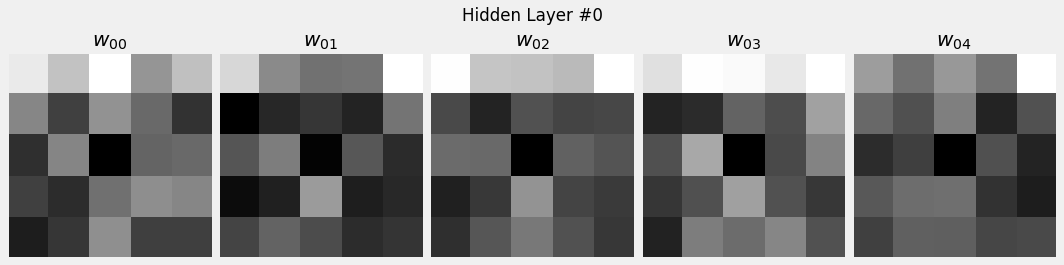

In [80]:
fig = figure7(w_nn_hidden0)

## Activation Functions


### Sigmoid

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

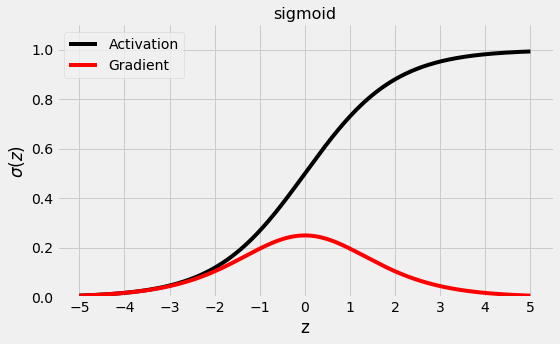

In [81]:
fig = plot_activation(torch.sigmoid)

In [82]:
dummy_z = torch.tensor([-3., 0., 3. ])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [83]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

### Hyberbolic Tangent (Tanh)

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

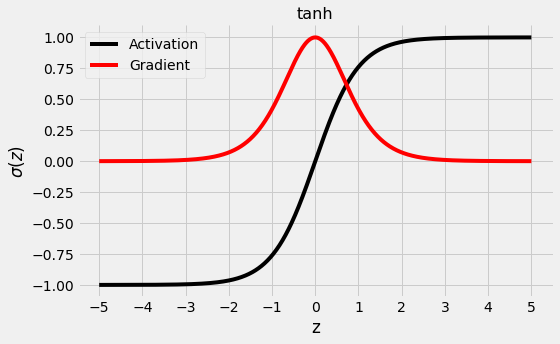

In [84]:
fig = plot_activation(torch.tanh)

In [85]:
dummyy_z = torch.tensor([3., 0., -3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [86]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

### Rectified Linear Unit (RiLU)

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ if\ \ z \ge 0
\\
0,\ if \ \ z < 0
\end{cases}
\\
& or
\\
\sigma(z) &= max(0, z)
\end{aligned}
$$

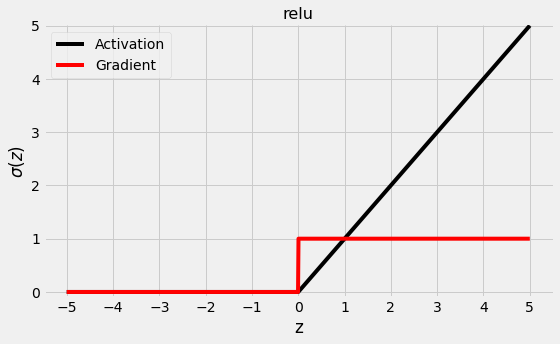

In [88]:
fig = plot_activation(torch.relu)

In [89]:
dummyy_z = torch.tensor([3., 0., -3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [92]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [93]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

### Leaky ReLU

$$
\Large
\sigma(z) =
\begin{cases}
z,\ if\ \ z \ge 0
\\
0.01z,\ if \ \ z < 0
\end{cases}
\\
or
\\
\Large
\sigma(z)=max(0,z)+0.01min(0,z)
$$

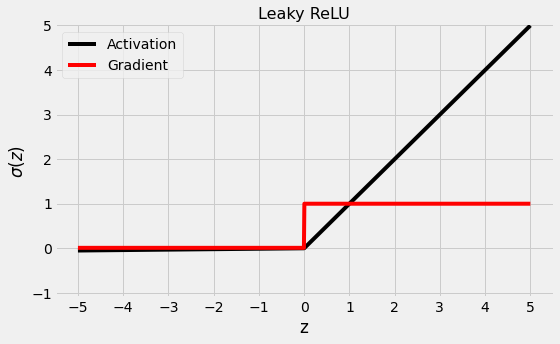

In [94]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

In [95]:
dummyy_z = torch.tensor([3., 0., -3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [96]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

### Parametric ReLU (PReLU)

$$
\Large
\sigma(z) =
\begin{cases}
z,\ if\ \ z \ge 0
\\
az,\ if \ \ z < 0
\end{cases}
\\
or
\\
\Large
\sigma(z)=max(0,z)+a\ min(0,z)
$$

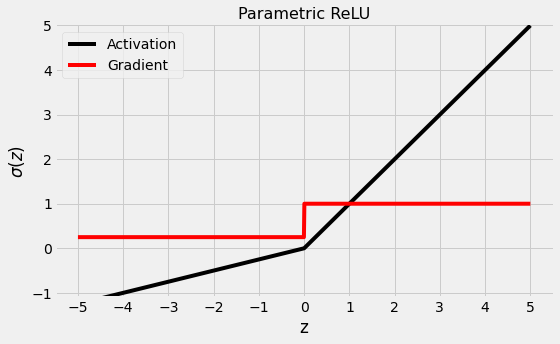

In [97]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

In [98]:
dummyy_z = torch.tensor([3., 0., -3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.7500,  0.0000,  3.0000])

In [99]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluBackward0>)

## Deep Model

### Model Configuration

In [100]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.01

torch.manual_seed(17)
# Now we can create a model 
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())


# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr) 

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()


### Model Training

In [101]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

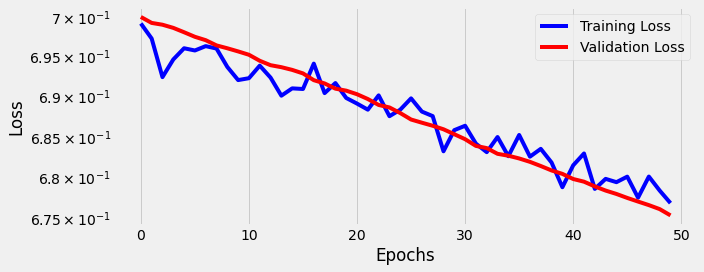

In [102]:
fig = sbs_relu.plot_losses()

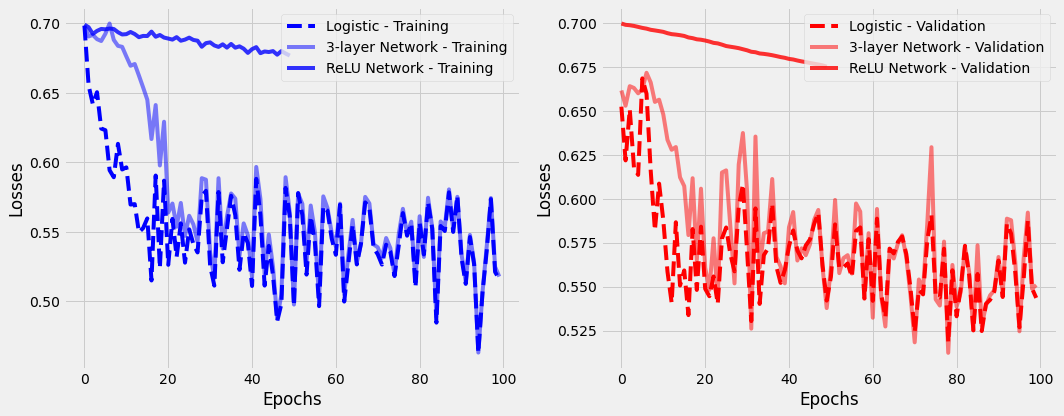

In [103]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)

### Show me Math again

## Putting It All Together

In [109]:
class TransformedTensorData(Dataset):
  def __init__(self, x, y, transform=None):
      self.x = x
      self.y = y
      self.transform = transform 

  def __getitem__(self, index):
      x = self.x[index]

      if self.transform:
        x = self.transform(x)

      return x, self.y[index]

  def __len__(self):
      return len(self.x)

In [113]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor 
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()
    split_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at first split 
    # so random_split does not complain 
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff 
    # Uses PyTorch random_split to split the indices 
    torch.manual_seed(seed)
    return random_split(idx, split_tensor)


In [114]:
def make_balanced_sampler(y):
    # computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with computer weights 
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights = sample_weights,
        num_samples = len(sample_weights),
        generator = generator,
        replacement = True
    )

    return sampler

In [115]:
# Builds tensors from numpy arrays BEFORE split 
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indicies for training and 
# validation sets

train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split 
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set 
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set 
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Build a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get balanced data loader 
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler) 
val_loader = DataLoader(dataset=val_dataset, batch_size=16) 

In [116]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter 
lr = 0.1

torch.manual_seed(11)
# Now we can create a model 
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [118]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)